In [6]:
# Import required libraries
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

### 1. Load the insurance data

In [24]:
# 1. Load the dataset
insurance = pd.read_csv('insurance_cleaned.csv')

In [81]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


### 2. Prepare data for modeling

In [39]:
#2. Prepare data for modeling

# Separate features and target
X = insurance.drop('charges', axis=1)
y = insurance['charges']

# Define feature types
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

# Convert categorical variables to dummy variables
X_categorical = pd.get_dummies(X[categorical_features], drop_first=True)

# Combine numerical and categorical features
X_processed = pd.concat([X[numerical_features], X_categorical], axis=1)

print(f"Features prepared. Shape: {X_processed.shape}")

Features prepared. Shape: (1148, 8)


In [51]:
X_processed.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19.0,27.900,0.0,False,True,False,False,True
1,18.0,33.770,1.0,True,False,False,True,False
2,28.0,33.000,3.0,True,False,False,True,False
3,33.0,22.705,0.0,True,False,True,False,False
4,32.0,28.880,0.0,True,False,True,False,False


### 3. Create and train the model

In [54]:
#3. Create and train the model
print("Training linear regression model...")

# Create pipeline with scaling and linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit the model
pipeline.fit(X_processed, y)

Training linear regression model...


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

### 4. Evaluate model performance using cross-validation

In [57]:
#4. Evaluate model performance using cross-validation
print("\nEvaluating model performance...")

mse_scores = -cross_val_score(pipeline, X_processed, y, cv=5, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(pipeline, X_processed, y, cv=5, scoring='r2')

mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Mean MSE: {mean_mse:,.2f}")
print(f"Mean R²: {mean_r2:.4f}")


Evaluating model performance...
Mean MSE: 37,461,140.97
Mean R²: 0.7449


### 5. Make predictions on validation data

In [60]:
#5. Make predictions on validation data
print("\nMaking predictions on validation data...")

# Load validation data
validation_data = pd.read_csv('validation_dataset.csv')
validation_data.head()


Making predictions on validation data...


,index,age,sex,bmi,children,smoker,region
0,0,18,female,24.090000,1,no,southeast
1,1,39,male,26.410000,0,yes,northeast
2,2,27,male,29.150000,0,yes,southeast
3,3,71,male,65.502135,13,yes,southeast
4,4,28,male,38.060000,0,no,southeast


In [66]:
# Keep only the features that were used in training (remove any extra columns like 'index')
training_features = ['age', 'bmi', 'children', 'sex', 'smoker', 'region']
validation_features = validation_data[training_features].copy()

# Process validation data the same way as training data
validation_categorical = pd.get_dummies(
    validation_features[['sex', 'smoker', 'region']], 
    drop_first=True
)

# Combine numerical and categorical features
validation_processed = pd.concat([
    validation_features[['age', 'bmi', 'children']], 
    validation_categorical
], axis=1)

# Ensure the validation data has the same columns as training data
# Get the column names from training
training_columns = X_processed.columns.tolist()

# Reindex validation data to match training columns (fills missing with 0)
validation_processed = validation_processed.reindex(columns=training_columns, fill_value=0)

print(f"Validation data processed. Shape: {validation_processed.shape}")

Validation data processed. Shape: (50, 8)


In [68]:
validation_processed.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,24.090000,1,False,False,False,True,False
1,39,26.410000,0,True,True,False,False,False
2,27,29.150000,0,True,True,False,True,False
3,71,65.502135,13,True,True,False,True,False
4,28,38.060000,0,True,False,False,True,False


In [72]:
# Make predictions
predictions = pipeline.predict(validation_processed)

# Add predictions to validation data
validation_data['predicted_charges'] = predictions

# Apply minimum charge constraint of $1000
validation_data.loc[validation_data['predicted_charges'] < 1000, 'predicted_charges'] = 1000

In [74]:
validation_data[['predicted_charges']].head()

,predicted_charges
0,1000.000000
1,30947.898691
2,27952.709062
3,56281.559399
4,7151.328860


In [76]:
validation_data.head()

,index,age,sex,bmi,children,smoker,region,predicted_charges
0,0,18,female,24.090000,1,no,southeast,1000.000000
1,1,39,male,26.410000,0,yes,northeast,30947.898691
2,2,27,male,29.150000,0,yes,southeast,27952.709062
3,3,71,male,65.502135,13,yes,southeast,56281.559399
4,4,28,male,38.060000,0,no,southeast,7151.328860


### 6. Visualize the distribution of predicted charges

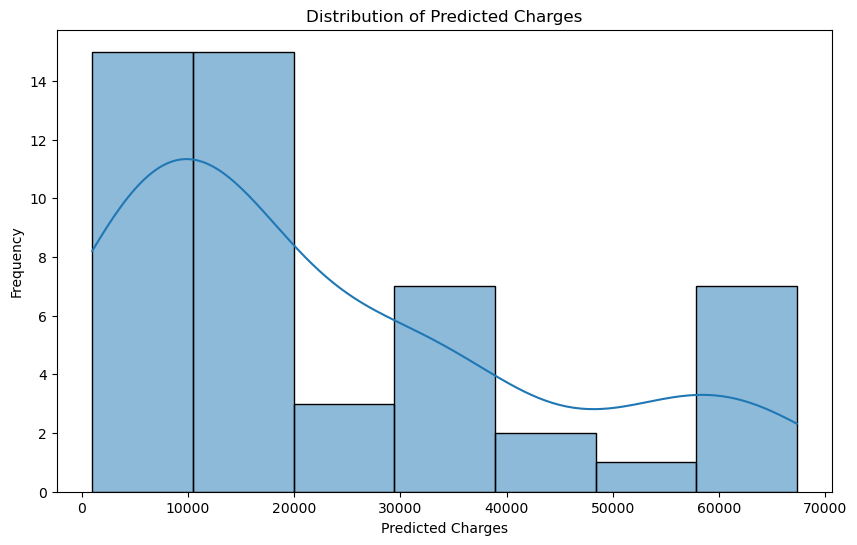

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of predicted charges
plt.figure(figsize=(10, 6))
sns.histplot(validation_data['predicted_charges'], kde=True)
plt.title('Distribution of Predicted Charges')
plt.xlabel('Predicted Charges')
plt.ylabel('Frequency')
plt.show()

### 7. Analyze model coefficients

In [98]:
# Analyze model coefficients
print("\nAnalyzing model coefficients...")

# Get the coefficients and feature names
coefficients = pipeline.named_steps['regressor'].coef_
features = X_processed.columns

# Create a DataFrame to display coefficients
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Sort coefficients by absolute value to see most impactful features
coefficients_df['Abs_Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

print("Model Coefficients:")
display(coefficients_df)


Analyzing model coefficients...
Model Coefficients:


,Feature,Coefficient,Abs_Coefficient
4,smoker_yes,9708.250305,9708.250305
0,age,3709.439661,3709.439661
1,bmi,2008.359995,2008.359995
2,children,446.752205,446.752205
7,region_southwest,-367.055668,367.055668
6,region_southeast,-331.459848,331.459848
5,region_northwest,-118.195648,118.195648
3,sex_male,-92.821193,92.821193


#### correlation

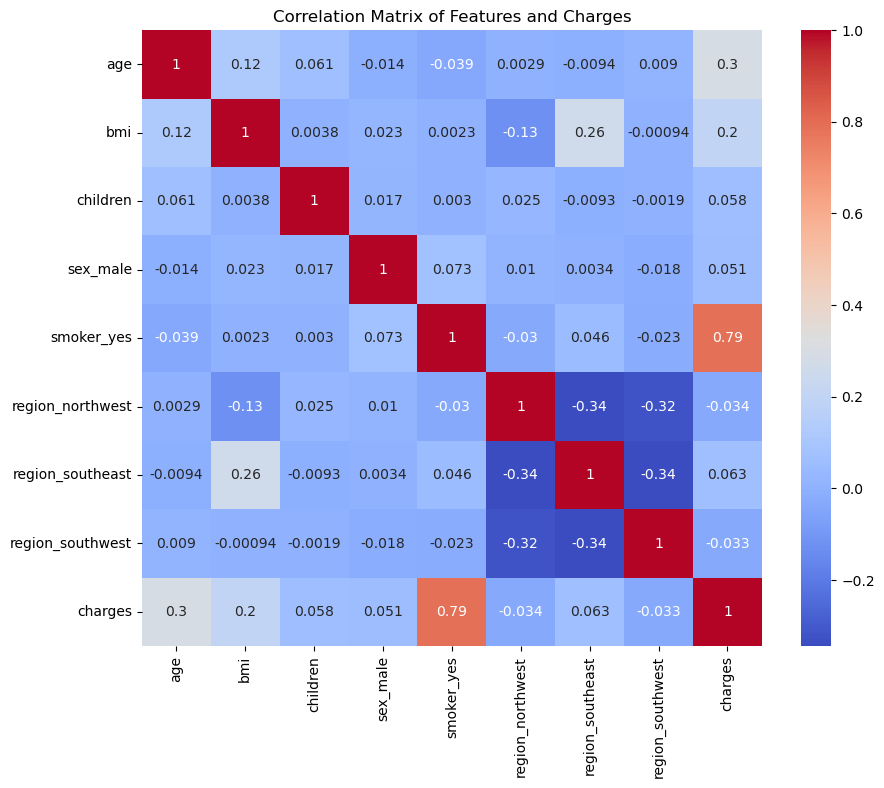

In [121]:
# Calculate the correlation matrix with the processed features and target
correlation_matrix = X_processed.copy()
correlation_matrix['charges'] = y

plt.figure(figsize=(10, 8)) # Increase the figure size
sns.heatmap(
    correlation_matrix.corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Correlation Matrix of Features and Charges')
plt.show()

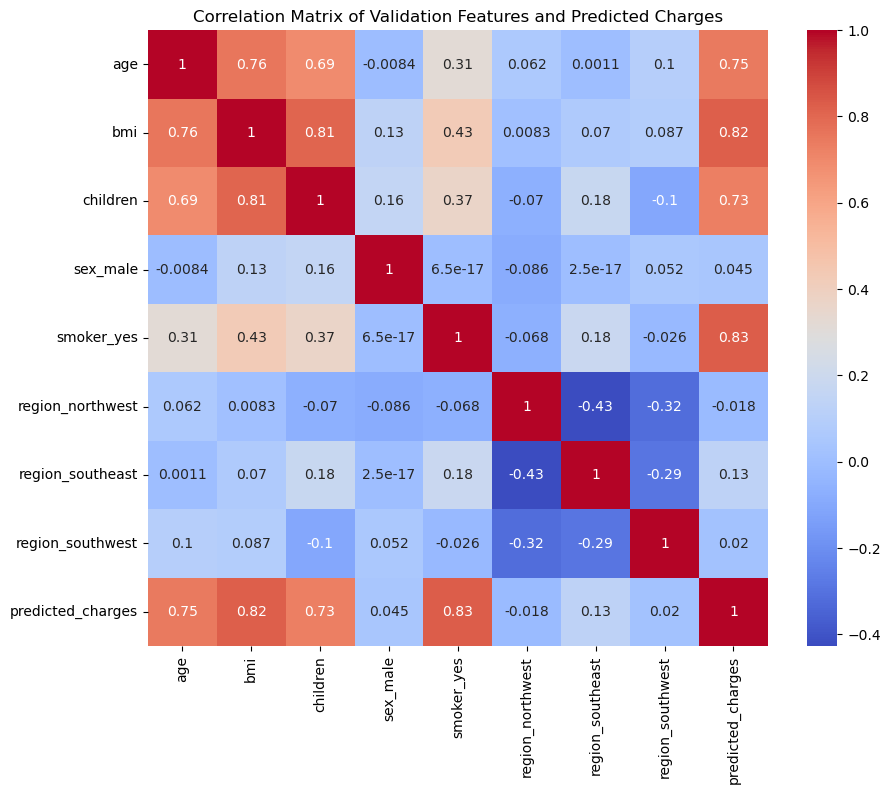

In [125]:
# Calculate the correlation matrix with the processed validation features and predicted charges
prediction_correlation_matrix = validation_processed.copy()
prediction_correlation_matrix['predicted_charges'] = validation_data['predicted_charges']

plt.figure(figsize=(10, 8))
sns.heatmap(
    prediction_correlation_matrix.corr(), 
    annot=True, 
    cmap='coolwarm'
)
plt.title('Correlation Matrix of Validation Features and Predicted Charges')
plt.show()

## Summary of Key Insights

Here's a breakdown of what we did and what we learned from the analysis:

1.  **Data Loading and Cleaning:** We loaded and cleaned the insurance dataset, handling data types, removing invalid entries, and standardizing values. The cleaned dataset contained 1149 records and 7 features.

2.  **Data Preparation for Modeling:** Features were separated from the target variable ('charges'). Categorical features were converted to numerical format using one-hot encoding.

3.  **Model Training:** A linear regression model was trained using a pipeline with feature scaling.

4.  **Model Evaluation:** The model was evaluated using 5-fold cross-validation, resulting in a mean Mean Squared Error (MSE) of approximately `37,461,140.97` and a mean R-squared (R²) of about `0.7449`. This indicates the model explains about `74.50%` of the variance in charges.

5.  **Prediction on Validation Data:** Predictions were made on a separate validation dataset after applying the same preprocessing steps. A minimum charge of `$1000` was applied to the predictions.

6.  **Visualization of Predicted Charges:** A histogram was generated to visualize the distribution of the predicted charges.

7.  **Analysis of Model Coefficients:** Analyzing the model's coefficients revealed the most influential factors in predicting insurance charges, in order of decreasing absolute impact:
    *   **Smoker:** Has the largest positive impact.
    *   **Age:** Significant positive impact.
    *   **BMI:** Notable positive impact.
    *   **Children:** Smaller positive impact.
    *   **Region:** Smaller impacts compared to the above, with some regions showing negative coefficients relative to the baseline.
    *   **Sex:** Smallest negative impact.

In conclusion, the model highlights that smoking, age, and BMI are the primary drivers of insurance charges, with smoking being the most significant factor. The model provides a reasonably good fit to the data.